# Raport Symulacje komputerowe 
#### Radosław Tertel 268738

#### Niniejszy raport dotyczy komputerowej symulacji zagadnień z zakresu rachunku prawdopodobieństwa i procesów stochastycznych. Każda komórka oraz sekcja będzie opisana na samym jej początku. W celu zachowania pewnej koncepcji, kod jest napisany w języku angielskim.

#### Ładowanie bibliotek 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.typing import ArrayLike   
import seaborn as sns 
import random
import scipy.stats as st
from scipy.special import lambertw
from typing import Callable, Tuple


# Zadanie 1
Zadanie pierwsze to implementacja algorytmu ACORN z uwzględnieniem pominięcia N pierwszych wyrazów. W tym celu została stworzona funkcja acorn(N,k,M,Lag). 
Przyjmuje ona jako argumenty długość próbki do wygenerowania, stopień algorytmu, liczbę modułową oraz liczbę pierwszych wyrazów do pominięcia. 
Algorytm opisany jest wzorem rekurencyjnym:
- $X_n^0=X^0_n$,$n\geq1$;;
- $X_n^m=(X_n^{m-1}+X_{n-1}^m)mod M$, $m=1,...,k$, $n\geq1$
- $Y_n^k=\frac{X_n^k}{M}$, $n\geq1$

In [3]:
def acorn(N:int,k:int,M:int,Lag:int) -> ArrayLike:
    ''' Funkcion is an implementation of the ACORN generator
        Args: N:int: number of variables to generate;
              k:int: order of the algorithm;
              M:int: Modulus>0, the best if it is power of 2 bigger than 2^60;
              Lag:int: number of elements to skip.
        Returns:
            ArrayLike: N pseudo-random numbers using k'th order ACORN algorithm with Lag first elements skipped with parameter M'''
    Xs=np.zeros((k,N+Lag))
    Xs[0,0]=13 
    for j in range(1,N+Lag):
        for i in range(k):
            if j-i-1>=0:
                Xs[i,j]=(Xs[i,j-1]+Xs[i-1,j-1])%M
    Ys=(Xs[0,Lag:N+Lag]/M)
    return Ys
         

#### Parametry i wizualizacja 


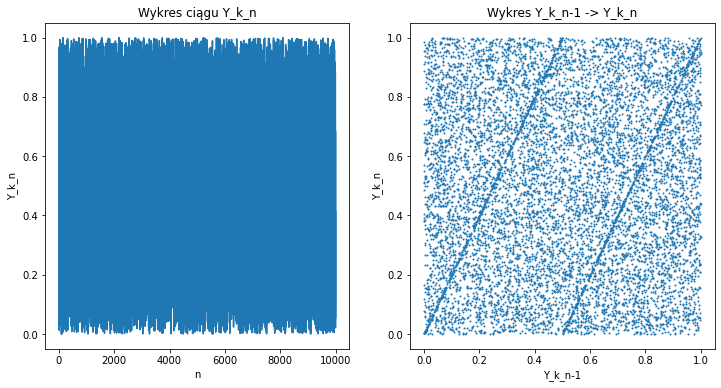

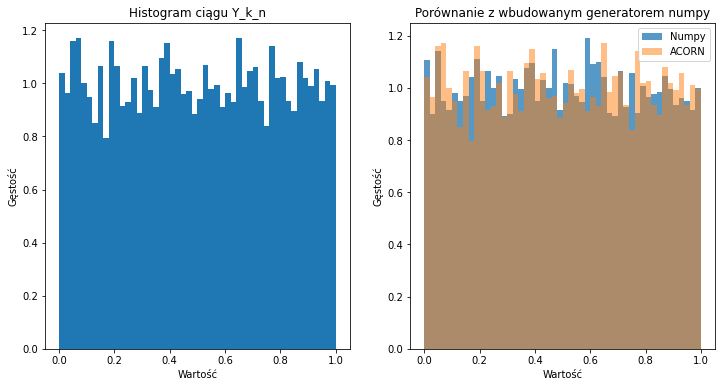

In [9]:
N=10**4
k=13
M=2**89-1
Lag=10**2
random_sequence = acorn(N, k, M, Lag)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(random_sequence)
plt.title("Plot of Y_k_n series")
plt.xlabel("n")
plt.ylabel("Y_k_n")

plt.subplot(1, 2, 2)
plt.scatter(random_sequence[:-1], random_sequence[1:], s=1)
plt.title("Plot of Y_k_n-1 -> Y_k_n")
plt.xlabel("Y_k_n-1")
plt.ylabel("Y_k_n")
plt.show()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(random_sequence, bins=50, density=True)
plt.title("Histogram of Y_k_n series")
plt.xlabel("value")
plt.ylabel("density")


np_random_sequence = np.random.uniform(0, 1, N)

plt.subplot(1, 2, 2)
plt.hist(np_random_sequence, bins=50, density=True, alpha=0.75, label="Numpy")
plt.hist(random_sequence, bins=50, density=True, alpha=0.5, label="ACORN")
plt.title("Comparison with build-in numpy generator")
plt.xlabel("value")
plt.ylabel("density")
plt.legend()
plt.show()

# Zadanie 2
Zadanie drugie dotyczy generacji rozkładu normalnego za pomocą dwóch metod. Po pierwsze jest to metoda tuzina, a po drugie metoda zigguratu.

#### Metoda tuzina
Algorytm przedstawia się następująco:
- Wygeneruj 12 liczb z rozkładu $U(0,1)$,
- Zdefiniuj $S=\sum_{i=1}^{12}U_i$,
- zdefiniuj $X=S-6$
- zwróć $Y=\sigma*X+\mu$

In [42]:
def twelves(mu:float=0, sigma:float=1) -> float:
    """ Generates a variable from normal distribution using the 'twelve' method.

        Args:
            mu:float: location of a normal distributed sample(mean parameter of normal distribution)
            sigma:float: variation of a normal distributed sample
        Returns:
            float: normal distributed variable generated using 'twelve' method"""
    sum_uniform = sum(random.uniform(0, 1) for _ in range(12))
    z = sum_uniform - 6
    z = z * (sigma /6**0.5)  
    return mu + z

#### Wizualizacja

Text(0.5, 1.0, 'Twelves method generation')

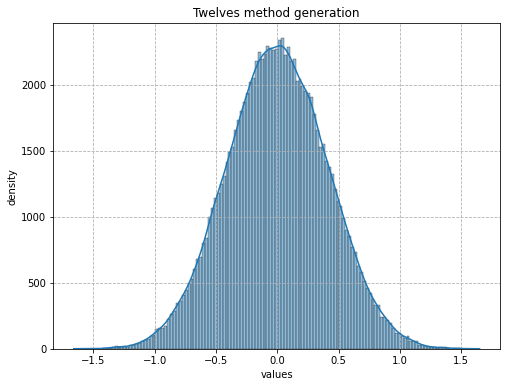

In [43]:
count = 100000
norm_values=np.empty(count)
for i in range(count):
    norm_values[i]=twelves()

plt.figure(figsize=(8,6))
sns.histplot(norm_values,kde=True)
plt.grid(linestyle="--")
plt.xlabel("values")
plt.ylabel("density")
plt.title("Twelves method generation")

#### Metoda zigguratu
W tym kodzie, metoda zigguratu została zaimplementowana za pomocą dwóch funkcji głównych i jednej asystującej. 
- initialize_ziggurat() inicjalizuje parametry potrzebne do rozpoczęcia algorytmu ziggurata,
- generate_normal() implementuje algorytm ziggurata przedstawiony na stronie podanej na wytycznych raportu,
- fix_normal() poprawia zmienne, które nie spełniają warunków na bycie z rozkładu normalnego.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def initialize_ziggurat() -> Tuple[ArrayLike,ArrayLike,ArrayLike]:
    """ Function initializes arrays with values of steps, weights and density function values used to generate
        normal distributed sample using ziggurat method.
        
        Returns:
            thresholds:ArrayLike: Steps values used to generate samples;
            weights:ArrayLike: Weights used to generate samples;
            density_values:ArrayLike: Values of normal density function.
        """
    m1 = 2**31  # Maksymalna wartość dla 32-bitowego integera, używana jako skala dla wartości progu.
    dn = 3.442619855899  # Początkowa wartość prawego ogona
    tn = dn
    vn = 9.91256303526217e-3  # Obszar pod krzywą
    q = vn / np.exp(-0.5 * dn * dn)

    thresholds = np.zeros(128, dtype=np.uint32)  # Tablica progów
    weights = np.zeros(128, dtype=np.float32)  # Tablica wag
    density_values = np.zeros(128, dtype=np.float32)  # Tablica wartości funkcji gęstości prawdopodobieństwa

    thresholds[0] = int(dn / q * m1)
    weights[0] = q / m1
    density_values[0] = 1.
    density_values[127] = np.exp(-0.5 * dn * dn)
    weights[127] = dn / m1

    for i in range(126, 0, -1):
        dn = np.sqrt(-2. * np.log(vn / dn + np.exp(-0.5 * dn * dn)))
        thresholds[i + 1] = int(dn / tn * m1)
        tn = dn
        density_values[i] = np.exp(-0.5 * dn * dn)
        weights[i] = dn / m1

    return thresholds, weights, density_values

def fix_normal(hz:int) -> float:
    """ Assisting function that repairs sample if it doesnt meet normal distribution condistions.

        Args:
            hz:int: sample that needs to be repaired
        Returns:
            float: repaired sample"""
    
    while True:
        x = -np.log(np.random.uniform()) * 0.2904764  # skala 1/r
        y = -np.log(np.random.uniform())
        if y + y > x * x:
            return (hz > 0) * (3.442620 + x) - (hz < 0) * (3.442620 + x)

def generate_normal(thresholds:ArrayLike, weights:ArrayLike, density_values:ArrayLike) -> float:
    """ Function generates variable from normal distribution using ziggurat algorithm.

        Args:
            thresholds:ArrayLike: Steps values used to generate samples;
            weights:ArrayLike: Weights used to generate samples;
            density_values:ArrayLike: Values of normal density function.
        Returns:
            float: generated variable from normal distribution
            """
    while True:
        hz = int(np.random.uniform(-2**31, 2**31))
        iz = hz & 127
        if abs(hz) < thresholds[iz]:
            return hz * weights[iz]
        elif iz == 0:
            return fix_normal(hz)
        else:
            x = hz * weights[iz]
            if density_values[iz] + np.random.uniform() * (density_values[iz - 1] - density_values[iz]) < np.exp(-0.5 * x * x):
                return x



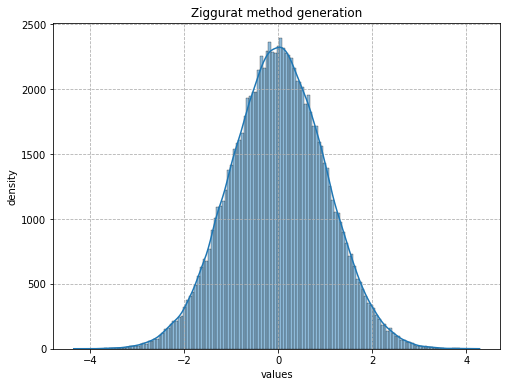

In [99]:
thresholds, weights, density_values = initialize_ziggurat()  
samples_normal = [generate_normal(thresholds, weights, density_values) for _ in range(1000)]  

thresholds, weights, density_values = initialize_ziggurat()  
samples_normal = [generate_normal(thresholds, weights, density_values) for _ in range(100000)] 

plt.figure(figsize=(8, 6))
sns.histplot(samples_normal,kde=True)
plt.grid(linestyle="--")
plt.title('Ziggurat method generation')
plt.xlabel('values')
plt.ylabel('density')
plt.show()

# Zadanie 3
Zadanie trzecie przedstawia numeryczne wyliczanie całki:
$$\int_0^{1} \frac{4}{1+x^2}dx$$
przybliżającej liczbę $\pi$ oraz na implementacji algorytmów redukujących wariancję. W tej pracy zaimplementowano algorytm zmiennej kontrolnej.

#### Zdefiniowanie funkcji
- Funkcja integral_standard() korzysta ze standardowej metody monte carlo do obliczania całek.
- Funkcja control_variate_integration wykorzystuje algorytm zmiennej kontrolnej w celu redukcji wariancji. Wykorzystuje on znaną całkę z jakiejkolwiek funkcji i wyliczając odpowiednie wpółczynniki na podstawie wartości znanej całki, estymuje całkę, którą chcemy oszacować. 
- Funkcja g() to funkcja znana, której całkę wykorzystano do funkcji z control_variate_integration() 

In [39]:
def integral_standard(f:Callable, a:float, b:float, n_samples:int) -> float:
    """ Function estimates integration using monte carlo method

        Args:
            f:Function: Function to integrate;
            a:float: bottom integration boundry;
            b:float: upper integration boundry;
            n_samples: number of monte carlo steps;
        Returns:
            integral estimation calculated using monte carlo method"""
    x_samples = np.random.uniform(a, b, n_samples)
    f_samples = f(x_samples)
    f_mean = np.mean(f_samples)
    integral_estimate = (b - a) * f_mean
    return integral_estimate

def control_variate_integration(f:Callable, g:Callable, g_integral:float, a:float, b:float, n_samples:int) -> float:
    """Function integrates using monte carlo method and control_variate method for variance reduction

       Args:
            f:function: function to integrate;
            g:function: control function, which integral is well known;
            g_integral:float: value of the g function integral;
            a:float: bottom integration boundry;
            b:float:top integration boundry;
            n_samples:int:number of monte carlo steps;
        Returns:
            float: integral estimation calculated with applied control_variate method
            float: standard error of the estimation."""
    
    x_samples = np.random.uniform(a, b, n_samples)
    f_samples = f(x_samples)
    g_samples = g(x_samples)
    
    f_mean = np.mean(f_samples)
    g_mean = np.mean(g_samples)
    
    covariance = np.cov(f_samples, g_samples, bias=True)[0][1]
    variance_g = np.var(g_samples, ddof=0)
    beta = covariance / variance_g

    integral_estimate = (b - a) * (f_mean - beta * (g_mean - g_integral))
    
    return integral_estimate

def f(x:float) -> float:
    """Function generating f(x)=1/(1+x^2)
       Args:
            x:float: argument of a function
       Returns:
            value of f(x) for given argument"""
    return 4/(1+x**2)

def g(x:float) -> float:
    return x

#### Wizualizacja tysiąca estymacji wartości całek wyestymowanych obiema metodami

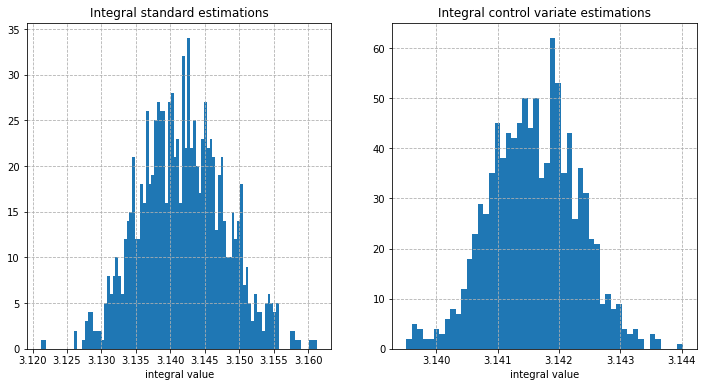

In [23]:
a = 0
b = 1
g_integral = (b**2 - a**2) / 2

n = 1000
n_samples=10000
standard_values=np.empty(n)
control_variate_values=np.empty(n)
for i in range(n):
    standard_values[i]=integral_standard(f,a,b,n_samples)
for i in range(n):
    control_variate_values[i]=control_variate_integration(f,g,g_integral,a,b,n_samples)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(standard_values,bins=100)
plt.title("Integral standard estimations")
plt.xlabel("integral value")
plt.grid(linestyle="--")
plt.subplot(1,2,2)
plt.hist(control_variate_values,bins=50)
plt.title("Integral control variate estimations")
plt.xlabel("integral_value")
plt.xlabel("integral value")
plt.grid(linestyle="--")
plt.show()


#### Już na pierwszy rzut oka widać, że estymacje metodą zmiennej kontrolnej są bardziej "zbite" i mają mniejsze odchylenie standardowe.
# Analiza Błędów
W tej sekcji zbadano:
- Wariancję,
- błąd standardowy,
- błąd względny,
- błąd bezwzględny
estymacji, w zależności od ilości kroków monte carlo wewnątrz algorytmu.

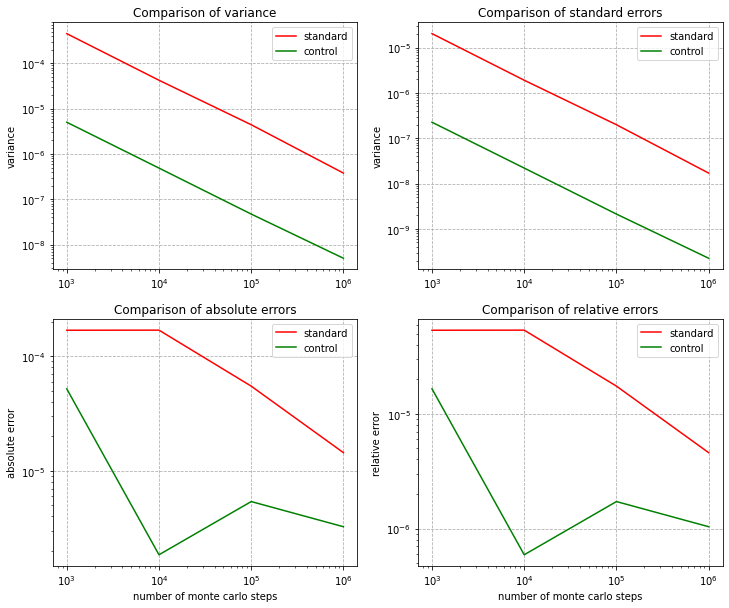

In [41]:
a = 0
b = 1
g_integral = (b**2 - a**2) / 2
n=500
ns=[1000,10000,100000,1000000]
st_errors_standard=np.empty(len(ns))
st_errors_control=np.empty(len(ns))
vars_standard=np.empty(len(ns))
vars_control=np.empty(len(ns))
absolute_err_standard=np.empty(len(ns))
absolute_err_control=np.empty(len(ns))
relative_err_standard=np.empty(len(ns))
relative_err_control=np.empty(len(ns))

for index,i in enumerate(ns):
    estimate_std =[integral_standard(f,a,b,i) for _ in range(n)]
    estimate_control=[control_variate_integration(f,g,g_integral,a,b,i) for _ in range(n)]
    vars_standard[index]=np.var(estimate_std)
    st_errors_standard[index]=np.var(estimate_std)/np.sqrt(n)
    vars_control[index]=np.var(estimate_control)
    st_errors_control[index]=np.var(estimate_control)/np.sqrt(n)
    absolute_err_standard[index]=abs(np.pi-np.mean(estimate_std))
    absolute_err_control[index]=abs(np.pi-np.mean(estimate_control))
    relative_err_standard[index]=(abs(np.pi-np.mean(estimate_std)))/np.pi
    relative_err_control[index]=(abs(np.pi-np.mean(estimate_control)))/np.pi

plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(ns,vars_standard,color="r",label="standard")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("variance")
plt.title("Comparison of variance")
plt.plot(ns,vars_control,color="g",label="control")
plt.grid(linestyle="--")
plt.legend()

plt.subplot(2,2,2)
plt.plot(ns,st_errors_standard,color="r",label="standard")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("variance")
plt.title("Comparison of standard errors")
plt.plot(ns,st_errors_control,color="g",label="control")
plt.grid(linestyle="--")
plt.legend()

plt.subplot(2,2,3)
plt.plot(ns,absolute_err_standard,color="r",label="standard")
plt.xlabel("number of monte carlo steps")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("absolute error")
plt.title("Comparison of absolute errors")
plt.plot(ns,absolute_err_control,color="g",label="control")
plt.grid(linestyle="--")
plt.legend()

plt.subplot(2,2,4)
plt.plot(ns,relative_err_standard,color="r",label="standard")
plt.xlabel("number of monte carlo steps")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("relative error")
plt.title("Comparison of relative errors")
plt.plot(ns,relative_err_control,color="g",label="control")
plt.grid(linestyle="--")
plt.legend()
plt.show()

#### Na wykresach, wykorzystując skalę logarytmiczną doskonale widać, że wariancje oraz błędy w przypadku metody zmiennej kontrolnej są znacząco mniejsze. 

# Zadanie 4
#### Część pierwsza
W tym zadaniu będzie to jedyna wykonana część. Niestety przez osamotnienie w wykonywaniu tego raportu, nie udało mi się przebrnąć do końca tego zadania. W pierwszej części należało wygenerować zmienną losową $Z=XY+sin(X)$, gdzie $X,Y$ pochodzą z rozkładu $N(0,1)$, oraz wyestymować $E[X|Y]$ i porównać z teoretyczną wartością wynoszącą $sin(x)$.

W tym celu zaimplementowano trzy funkcje odpowiednio:
- z() generującą podaną zienną losową,
- estimate_Z() obliczającą warunkową wartość oczekiwaną $E[X|Y]$,
- plot_data() Wyświetlającą wyniki na wykresie.

In [26]:
def z(n:int) ->Tuple[ArrayLike,ArrayLike,ArrayLike]:
    """ Generates random data for X~N(0,1), Y~N(0,1), and Z=XY+sin(X).
        Args:
            n:int: Size of the sample.
        Returns:
            tuple: Arrays of X, Y, and Z."""
    X = np.random.normal(0, 1, n)
    Y = np.random.normal(0, 1, n)
    Z = X * Y + np.sin(X)
    return X, Y, Z

def estimate_Z(X:ArrayLike, Z, num_bins):
    """ Estimate the expected value of Z given X using binning.

        Args:
            X (array-like): Input array X.
            Z (array-like): Input array Z.
            num_bins (int): Number of bins to use for estimation.
        Returns:
            tuple: Bins and estimated values of Z."""
    bins = np.linspace(X.min(), X.max(), num_bins)
    bin_indices = np.digitize(X, bins)
    Z_estimated = np.array([Z[bin_indices == i].mean() for i in range(1, num_bins)])
    return bins, Z_estimated

def plot_data(X, Z, bins, Z_estimated, n):
    lin = np.linspace(X.min(), X.max(), n)
    bin_centers = (bins[1:] + bins[:-1]) / 2

    plt.figure(figsize=(8, 6))
    plt.scatter(X, Z, color="grey", alpha=0.3, label="Simulated values")
    plt.scatter(bin_centers, Z_estimated,color="b" ,label="Estimated E[Z|X]")
    plt.plot(lin, np.sin(lin), color="r", label="theoretical E[Z|X]")
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.legend()
    plt.ylim([-5, 5])
    plt.title("Simulated values of Z + theoretical and estimated E[Z|X]")
    plt.grid(True)
    plt.show()


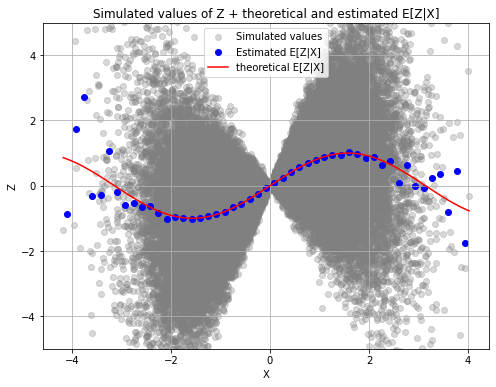

In [27]:
n = 100000
num_bins = 50

X, Y, Z = z(n)
bins, Z_estimated = estimate_Z(X, Z, num_bins)
plot_data(X, Z, bins, Z_estimated, n)

#### Na wykresie jasno widać, że estymowane wartości oczekiwane pokrywają się z teoretyczną na odcinku od około -2 do 2.

# Zadanie 5
Zadanie piąte polega na przeprowadzeniu badania odpowiednich własności procesu ruiny danego wzorem:
$$ R(t) = u + c(t) - \sum_{i = 1}^{N(t)} X_i, $$
gdzie:
- $u$ to kapitał początkowy, 
- $c$ to stałe, cykliczne zarobki(np. składki na ubezpieczenie w przypadku ubezpieczalni),
- $N_t$ to liczba skoków procesu poissona w czasie t o danej intensywności $\eta$.



Aby wykonać zadanie zaimplementowano dwie funkcje:
- poisson_process() generującą sumę skoków procesu poissona do czasu T,
- ruin_process() generującą proces ruiny

In [24]:
def poisson_process(T:int,lam:float) -> list:
     """Function generates poisson process
        Args:
             T:int: time
             lam:float>0: intensity of Poisson process
        Returns:
             list of poisson process values"""
     if lam<=0:
         raise ValueError("Wrong lam value! Has to be positive!")
     sum = 0
     results = []
     while True:
        sum += np.random.exponential(1/lam)
        if sum < T:
            results.append(sum)
        else:
            return(results)

def ruin_process(T:ArrayLike,lam:float,jot:float,u:float,c:float) -> ArrayLike:
    """ Function generates Cramer-Lundberg ruin process
        Args:
            T:int: process running time;
            lam: float>0: intensity of Poisson process;
            jot:float>0: intensity of dissaster appearance(exponential distribution parameter);
            u: float>0: starting value;
            c: float>0: earnings/salary amount;
        Returns:
            two arrays of time and values"""
    time=poisson_process(T,lam)
    d = st.expon(scale=jot)
    damages = d.rvs(len(time))
    ts = np.arange(0, T, 0.1)
    idx = []
    for t in time:
        for i, ts_val in enumerate(ts):
            if t < ts_val:
                idx.append(i)
                break
    incomes = c * ts
    for i, j in enumerate(idx):
        incomes[j:] -= damages[i]
    steps = u + incomes
    return ts, steps

#### Wizualizacja pojedynczej trajektorii procesu ruiny o parametrach widocznych w komórce kodu poniżej

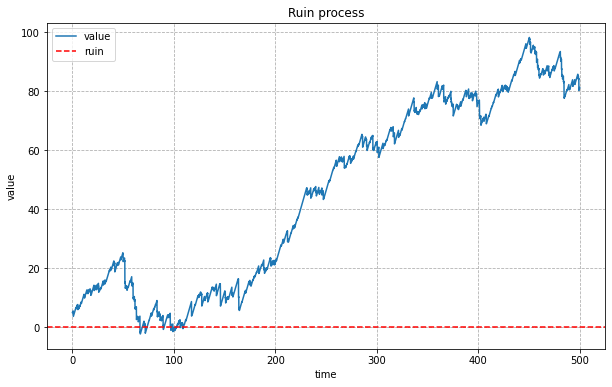

In [26]:
T = 500
lam = 1
jot=1
u = 5
c = 1.2
    
    
ts, steps = ruin_process(T, lam, jot, u, c)
    
plt.figure(figsize=(10,6))
plt.plot(ts, steps, label="value")
plt.axhline(y=0,color="r",linestyle="--",label="ruin")
plt.xlabel("time")
plt.ylabel("value")
plt.title("Ruin process")
plt.legend()
plt.grid(linestyle="--")
plt.show()

#### Dwie rzeczy, które zbadano w tym zadaniu to poprawność wzoru Pollaczka-Chinczyna oraz jego odwrotności. Oba wzory zaimplementowane są w funkcjach widocznych w poniższej komórce z kodem.

In [27]:
def Pollaczek(u:float,c:float,jot:float,lam:float)->float:
    """Function counts a probability of ruin using Pollaczek-Khinchine formula; 
       Args: 
            u:Starting value;
            c: ;
            jot: intensity of distribution of ruin probability;
            lam: intensity of poisson process;
       Returns:
            Value of Probability of ruin in infinite time ruin process
            """
    if lam*jot>=c:
        return 1
    return (jot*lam/c)*np.exp(-((1/jot)-(lam/c))*u)

def reverse_Pollaczek(u:float,jot:float,lam:float,psi:float) ->float:
    """Function counts a probability of ruin using Pollaczek-Khinchine formula; 
       Args: 
            u:Starting value;
            c: ;
            jot: intensity of distribution of ruin probability;
            lam: intensity of poisson process;
            psi: Expected probability of ruin (0,1);
       Returns:
            Value of Probability of ruin in infinite time ruin process
            """
    return (lam*u)/lambertw((u*psi*np.exp(u/jot))/jot)

#### Zliczanie prawdopodobieństwa symulacyjnie

In [33]:
def calculate_ruin_probability(num_simulations, T, lam, jot, u, c):
    """Calculates the probability of ruin using multiple simulations.
    Args:
        num_simulations: int: number of simulations to run;
        T: int: process running time;
        lam: float>0: intensity of Poisson process;
        jot: float>0: intensity of disaster appearance (exponential distribution parameter);
        u: float>0: starting value;
        c: float>0: earnings/salary amount;
    Returns:
        Estimated probability of ruin
    """
    ruin_count = 0
    for _ in range(num_simulations):
        steps = ruin_process(T, lam, jot, u, c)[1]
        if np.any(steps < 0):
            ruin_count += 1

    ruin_probability = ruin_count / num_simulations
    return ruin_probability

In [34]:
num_simulations = 1000  
ruin_prob = calculate_ruin_probability(num_simulations, T, lam, jot, u, c)
print(f"Prawdopodobieństwo ruiny: {ruin_prob}")

Prawdopodobieństwo ruiny: 0.362


In [90]:
print(f"Prawdopdobieństwo ruiny wyznaczone ze wzoru Pollaczka-Chinczyna:{Pollaczek(u,c,jot,lam)}")

Prawdopdobieństwo ruiny wyznaczone ze wzoru Pollaczka-Chinczyna:0.36216517375589863


#### Kolejnym etapem było zbadanie zachowania procesu ruiny przy zmianie kolejno parametru c oraz u. Zbadano jak zmienia się prawdopodobieństwo ruiny oraz wyrysowano trajektorie procesu.

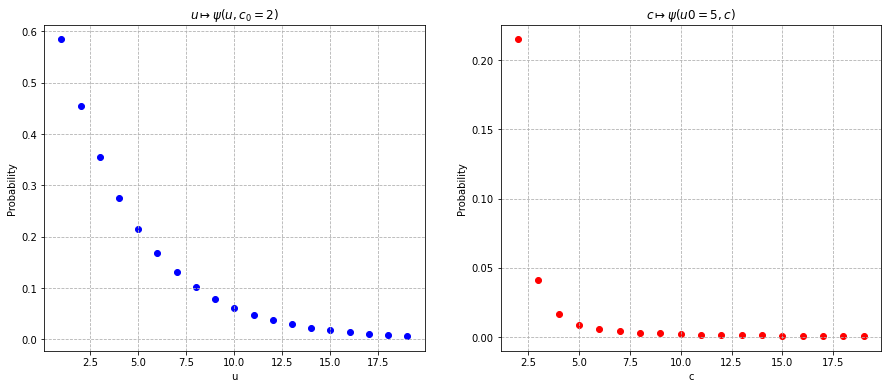

In [32]:

us=np.arange(1,20,1)
jot=1
lam=1.5
c0=2
u0=5
cs=np.arange(2,20,1)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
for u in us:
    plt.scatter(u,Pollaczek(u,c0,jot,lam),color="b")
plt.title(r'$u \mapsto \psi(u,c_0=2)$')
plt.xlabel("u")
plt.ylabel("Probability")
plt.grid(linestyle="--")
plt.subplot(1,2,2)
for c in cs:
    plt.scatter(c,Pollaczek(u0,c,jot,lam),color="r")

plt.title(r'$c \mapsto \psi(u0=5,c)$')
plt.xlabel("c")
plt.ylabel("Probability")
plt.grid(linestyle="--")
plt.show()
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


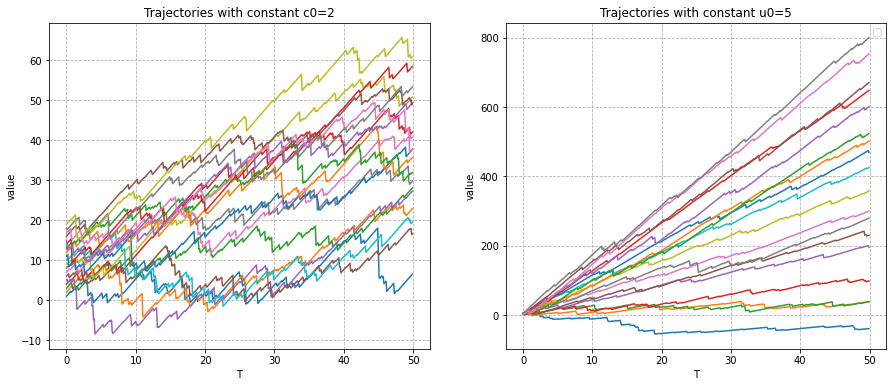

In [17]:
us=np.arange(1,20,1)
jot=1
jot2=3
lam=1.5
lam2=1
c0=2
u0=5

cs=np.arange(2,20,1)
T=50
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
for u in us:
    ts,steps=ruin_process(T,lam,jot,u,c0)
    plt.plot(ts,steps)
plt.title("Trajectories with constant c0=2")
plt.xlabel("T")
plt.ylabel("value")
plt.grid(linestyle="--")
plt.subplot(1,2,2)
for c in cs:
    ts,steps=ruin_process(T,lam2,jot2,u0,c)
    plt.plot(ts,steps)
plt.legend()
plt.title("Trajectories with constant u0=5")
plt.xlabel("T")
plt.ylabel("value")
plt.grid(linestyle="--")
plt.show()

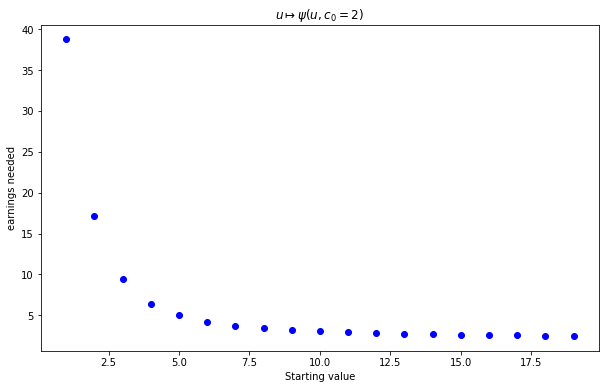

In [30]:
us=np.arange(1,20,1)
jot=1
lam=2
c0=2
u0=5
psi=0.02
plt.figure(figsize=(10,6))
for u in us:
    plt.scatter(u,reverse_Pollaczek(u,jot,lam,psi),color="b")
plt.title(r'$u \mapsto \psi(u,c_0=2)$')
plt.xlabel("Starting value")
plt.ylabel("earnings needed")
plt.show()


# Zadanie 6
W tym zadaniu zweryfikowano symulacyjnie prawa rozkładu Arcusa sinusa dotyczące pewnych zachowań procesu Wienera, które posiadają ten rozkład.

Najpierw zdefiniowano funkcje generujące teoretyczną gęstość oraz dystrybuantę rozkładu arcusa sinusa, a także funkcję generującą proces Wienera, inaczej zwany ruchem Browna. 

In [46]:
def arcsine_pdf(x:ArrayLike)->ArrayLike:
    pdf = np.where((x > 0) & (x < 1), 1 / (np.pi * np.sqrt(x * (1 - x))),0)

    return pdf

def arcsine_cdf(x:ArrayLike):
    cdf = np.zeros_like(x)
    cdf = np.where(x < 0, 0, cdf)
    cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)
    cdf = np.where(x > 1, 1, cdf)
    return cdf

def wiener_process(delta:float,dt:float,n:int) ->ArrayLike:
    """Function generates values of steps in wiener process.
       Args:
            delta:float: Wiener Process parameter;
            n: number of steps to iterate"""

    x=0.0
    r=np.empty(n)
    for i in range(n):
        x=x+st.norm.rvs(scale=delta**2*dt)
        r[i]=x
    return r

def arcsine():
    x=np.arange(0,1,0.01)
    return 1 / (np.pi * np.sqrt(x * (1 - x)))




#### Próbna wizualizacja procesu Wienera

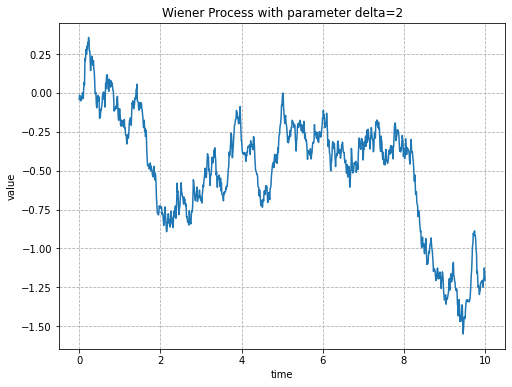

In [44]:
delta = 2
T = 10.0
N = 1000
dt = T/N
t=np.linspace(0,T,N)
plt.figure(figsize=(8,6))
plt.plot(t,wiener_process(delta,dt,N))
plt.title(f"Wiener Process with parameter delta={delta}")
plt.xlabel("time")
plt.ylabel("value")
plt.grid(linestyle="--")

#### Wizualizacja teoretycznej gęstości oraz dystrybuanty rozkładu Arcusa sinusa

C:\Users\beczk\AppData\Local\Temp\ipykernel_25496\3665559793.py:9: RuntimeWarning: invalid value encountered in sqrt
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)
C:\Users\beczk\AppData\Local\Temp\ipykernel_25496\3665559793.py:9: RuntimeWarning: invalid value encountered in arcsin
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)


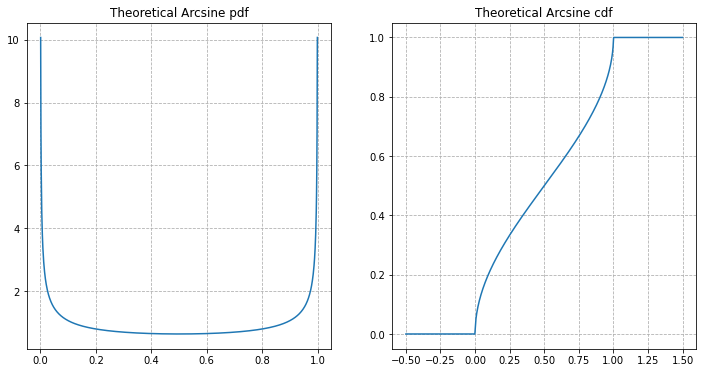

In [46]:
t=np.linspace(0.001,0.999,1000)
x=np.linspace(-0.5,1.5,1000)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(t,arcsine_pdf(t))
plt.grid(linestyle="--")
plt.title("Theoretical Arcsine pdf")
plt.subplot(1,2,2)
plt.plot(x,arcsine_cdf(x))
plt.grid(linestyle="--")
plt.title("Theoretical Arcsine cdf")
plt.show()

#### Kolejnym krokiem było zdefiniowanie funkcji do symulacyjnego generowania pierwszego, drugiego oraz trzeciego prawa arcusa sinusa.
W tym celu napisano funkcje które zwracają daną ilość zmiennych losowych będących kolejno:
- czasem, kiedy proces Wienera jest ponad osią $OX$ na odcinku $[0,1]$,
- ostatnim czasem uderzenia procesu o oś $OX$ na odcinku $[0,1]$,
- czas, kiedy proces osiąga swoje maksimum na ocinku $[0,1]$.

In [44]:
def first_law(delta:float,size:int) ->ArrayLike:
    """ Function generates a distribution of time over x axis of Wiener process on [0,1].

        Args:
            delta:float:Wiener process parameter;
            size:int:sample size to estimate;
        Returns:
            ArrayLike: scaled random variable"""
    X=np.empty(size)
    for i in range(size):
        process=wiener_process(delta,0.01,100) 
        count=0
        for j in process:
            if j>0:
                count+=1
        X[i]=count
    return X/100

def second_law(delta:float, size:int):
    """ Function generates a distribution of last time when Wiener process hits X axis on [0,1].

        Args:
            delta:float:Wiener process parameter;
            size:int:sample size to estimate;
        Returns:
            ArrayLike: scaled random variable"""
    X=np.empty(size)
    for i in range(size):
        process=wiener_process(delta,0.001,1000)
        for j in range(len(process)):
            if process[j-1]*process[i]<0:
                last_hit=(j-1)*0.001
            elif process[j]==0:
                last_hit=j*0.001
        X[i]=last_hit
    return X
def third_law(delta, size):
    """ Function generates a distribution of time when Wiener process reach maximum on [0,1].

        Args:
            delta:float:Wiener process parameter;
            size:int:sample size to estimate;
        Returns:
            ArrayLike: scaled random variable"""
    X=np.empty(size)
    for i in range(size):
        process=wiener_process(delta,0.001,1000)
        X[i]=np.argmax(process)*0.001
    return X


#### Porównanie histogramów oraz dystrybuant dla wysymulowanych zmiennych z teoretyczną zmienną losową o tym rozkładzie

C:\Users\beczk\AppData\Local\Temp\ipykernel_25496\3665559793.py:9: RuntimeWarning: invalid value encountered in sqrt
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)
C:\Users\beczk\AppData\Local\Temp\ipykernel_25496\3665559793.py:9: RuntimeWarning: invalid value encountered in arcsin
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)


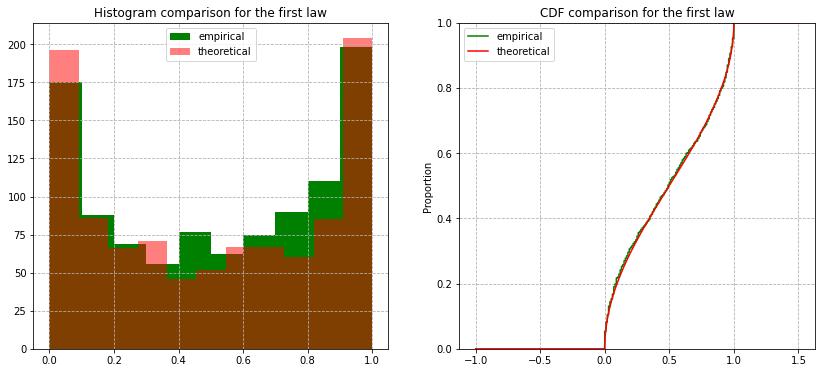

In [88]:
s=1000
r=st.arcsine.rvs(size=s)
t=np.linspace(-1,1.5,1000)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(first_law(0.5,s),color="g",label="empirical")
plt.hist(r, bins='auto', histtype='stepfilled', alpha=0.5,color="r",label="theoretical")
plt.grid(linestyle="--")
plt.title("Histogram comparison for the first law")
plt.legend()
plt.subplot(1,2,2)
sns.ecdfplot(data=first_law(0.5,s),color="g",label="empirical")
plt.plot(t,arcsine_cdf(t),color="r",label="theoretical")
plt.grid(linestyle="--")
plt.title("CDF comparison for the first law")
plt.legend()
plt.show()

C:\Users\beczk\AppData\Local\Temp\ipykernel_25496\3665559793.py:9: RuntimeWarning: invalid value encountered in sqrt
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)
C:\Users\beczk\AppData\Local\Temp\ipykernel_25496\3665559793.py:9: RuntimeWarning: invalid value encountered in arcsin
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)


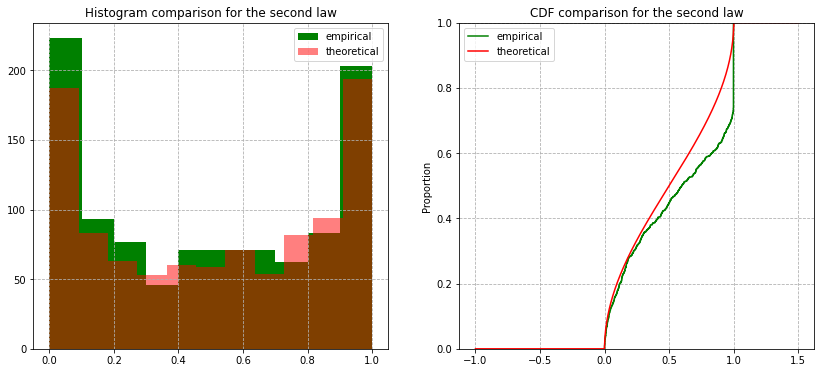

In [82]:
s=1000
r=st.arcsine.rvs(size=s)
t=np.linspace(-1,1.5,1000)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(first_law(0.5,s),color="g",label="empirical")
plt.hist(r, bins='auto', histtype='stepfilled', alpha=0.5,color="r",label="theoretical")
plt.grid(linestyle="--")
plt.title("Histogram comparison for the second law")
plt.legend()
plt.subplot(1,2,2)
sns.ecdfplot(data=second_law(0.5,s),color="g",label="empirical")
plt.plot(t,arcsine_cdf(t),color="r",label="theoretical")
plt.grid(linestyle="--")
plt.title("CDF comparison for the second law")
plt.legend()
plt.show()

C:\Users\beczk\AppData\Local\Temp\ipykernel_28076\262425900.py:9: RuntimeWarning: invalid value encountered in sqrt
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)
C:\Users\beczk\AppData\Local\Temp\ipykernel_28076\262425900.py:9: RuntimeWarning: invalid value encountered in arcsin
  cdf = np.where((x >= 0) & (x <= 1), (2 / np.pi) * np.arcsin(np.sqrt(x)), cdf)


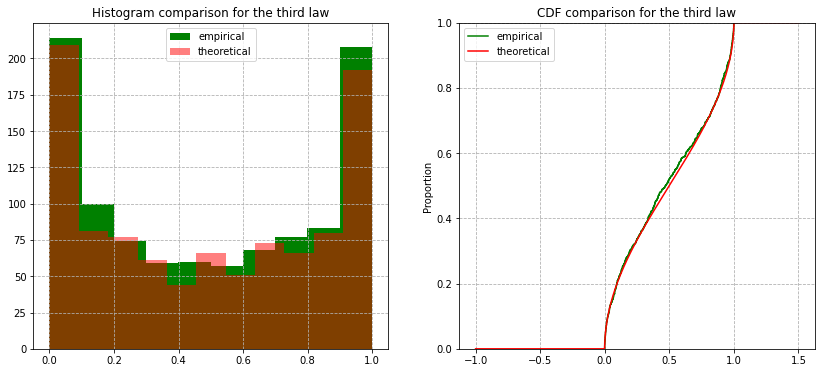

In [47]:
s=1000
r=st.arcsine.rvs(size=s)
t=np.linspace(-1,1.5,1000)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(third_law(0.5,s),color="g",label="empirical")
plt.hist(r, bins='auto', histtype='stepfilled', alpha=0.5,color="r",label="theoretical")
plt.grid(linestyle="--")
plt.title("Histogram comparison for the third law")
plt.legend()
plt.subplot(1,2,2)
sns.ecdfplot(data=third_law(0.5,s),color="g",label="empirical")
plt.plot(t,arcsine_cdf(t),color="r",label="theoretical")
plt.grid(linestyle="--")
plt.title("CDF comparison for the third law")
plt.legend()
plt.show()

#### Po symulacyjnej weryfikacji trzech praw, można dojść do wniosku, że rzeczywiście są one spełniane i jedyne odchylenie jest widoczne dla drugiego prawa arcusa w pobliżu końca odcinka.
